# Week 5 Assigmnent - Advanced Supervised Learning

**Grad 509: Dimensionality Reduction Assignment**

Your task is to develop a Support Vector Machine (SVM) algorithm to solve a real-world problem of identifying the species of Iris Plants. The dataset Module_5_data (see below csv file) is a modified dataset from the original Iris dataset. Your task is to determine whether a given Iris Plant belongs to the Setosa or the Versicolor based on four features: sepal length, sepal width, petal length, and petal width.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay,
    roc_auc_score, RocCurveDisplay, classification_report
)

iris = pd.read_csv('Model_5_data.csv')

In [2]:
iris

,sepal length (standardized),sepal width (standardized),petal length (standardized),petal width (standardized),species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
95,5.7,3.0,4.2,1.2,1
96,5.7,2.9,4.2,1.3,1
97,6.2,2.9,4.3,1.3,1
98,5.1,2.5,3.0,1.1,1


In [7]:
X_full = iris.drop('species',axis=1)
y_full = iris['species']

# Filter to a binary problem: Setosa (0) vs Versicolor (1) - just in case there is another species leak
mask = (y_full != 2)
X = X_full[mask]
y = y_full[mask]

print("X shape:", X.shape, "y shape:", y.shape)
print("Class distribution (Setosa=0, Versicolor=1):", {int(c): int((y==c).sum()) for c in np.unique(y)})

X shape: (100, 4) y shape: (100,)
Class distribution (Setosa=0, Versicolor=1): {0: 50, 1: 50}


After doing a review on the internet, and interesting suggestion for feature engineer is to add the ratio between the sepal and petal lenght with its width. 

In [8]:
# -----------------------------
# 2) FEATURE ENGINEERING & TRANSFORMATION
#    - Standardize features (SVMs are scale-sensitive)
#    - Optionally add simple ratios that are sometimes discriminative
# -----------------------------
# (Optional) Augment with two simple engineered features:

X = X.to_numpy()
y = y.to_numpy()

sepal_ratio = (X[:, 0] / np.maximum(X[:, 1], 1e-6)).reshape(-1, 1)   # sepal_length / sepal_width
petal_ratio = (X[:, 2] / np.maximum(X[:, 3], 1e-6)).reshape(-1, 1)   # petal_length / petal_width
X_aug = np.hstack([X, sepal_ratio, petal_ratio])

Now before training the model, I will split into to sets (train and test). The split will be stratify so the ratio between Setosa and Versicolor is conserve in both sets

In [ ]:
# -----------------------------
# 3) TRAIN/TEST SPLIT (stratified)
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_aug, y, test_size=0.30, random_state=24, stratify=y
) # use 70% 30% so we have enough data in test

In theory, the data is standarized, based on column name, by as we have add new features, and to be sure I will perform and standarization. Also I will leverage on the **Pipeline class of Scikit-Learn** to handle both standarization and model on the same python object.

In [13]:
# -----------------------------
# 4) MODEL: SVM in a Pipeline
#    - StandardScaler -> SVC
#    - Grid search over linear and RBF kernels
# -----------------------------
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("svc", SVC(probability=True))  # probability=True for ROC; slight overhead
])

This part goes beyong what we have seen in the course. But as we can train both SVC using linear separation (classic SVM), or using kernel methond, I will perform a hyperparameter tunning, to see which is the best model. 

In [14]:
# Sensible hyperparameter ranges for this problem:
# - RBF: keep search compact to avoid overfitting on tiny data.
param_grid = [
    {
        "svc__kernel": ["linear"],
        "svc__C": [0.01, 0.02, 0.05, 0.1, 0.2]
    },
    {
        "svc__kernel": ["rbf"],
        "svc__C": [0.01, 0.02, 0.05, 0.1, 0.2],
        "svc__gamma": ["scale", 0.01, 0.1, 1]
    }
]

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    refit=True,
    verbose=0
)
grid.fit(X_train, y_train)

,estimator,Pipeline(step...ility=True))])
,param_grid,"[{'svc__C': [0.01, 0.02, ...], 'svc__kernel': ['linear']}, {'svc__C': [0.01, 0.02, ...], 'svc__gamma': ['scale', 0.01, ...], 'svc__kernel': ['rbf']}]"
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,copy,True


In [15]:
print("\nBest params:", grid.best_params_)
print("CV best score (roc_auc):", f"{grid.best_score_:.4f}")

best_model = grid.best_estimator_


Best params: {'svc__C': 0.01, 'svc__kernel': 'linear'}
CV best score (roc_auc): 1.0000


From model training results, we see that linear is the best choose. And the optimal regularization parameter is 0.01. Now we will see the results on the test set.


=== Test Metrics ===
Accuracy : 1.0000
Precision: 1.0000
Recall   : 1.0000
F1-score : 1.0000
ROC-AUC  : 1.0000

              precision    recall  f1-score   support

      Setosa       1.00      1.00      1.00        15
  Versicolor       1.00      1.00      1.00        15

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



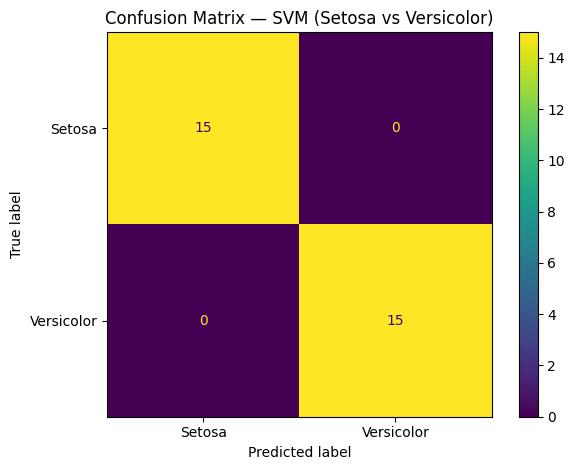

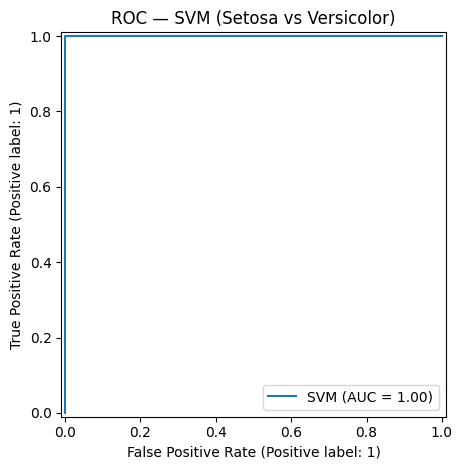

In [16]:
# -----------------------------
# 5) EVALUATION on hold-out test set
# -----------------------------
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec  = recall_score(y_test, y_pred)
f1   = f1_score(y_test, y_pred)
auc  = roc_auc_score(y_test, y_proba)

print("\n=== Test Metrics ===")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1:.4f}")
print(f"ROC-AUC  : {auc:.4f}\n")
print(classification_report(y_test, y_pred, target_names=["Setosa", "Versicolor"]))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Setosa", "Versicolor"])
disp.plot(values_format="d")
plt.title("Confusion Matrix — SVM (Setosa vs Versicolor)")
plt.tight_layout()
plt.show()

# ROC Curve
RocCurveDisplay.from_predictions(y_test, y_proba, name="SVM")
plt.title("ROC — SVM (Setosa vs Versicolor)")
plt.tight_layout()
plt.show()

We see that the results are impresive. This probably happen because the data is relative simple, and perfectly linear separable:

In [20]:
feature_name = ['sepal length (standardized)', 'sepal width (standardized)', 'petal length (standardized)', 'petal width (standardized)','sepal_ratio','petal_ratio']

In [21]:
# -----------------------------
# 6) INTERPRETABILITY HINT
# -----------------------------
if grid.best_params_.get("svc__kernel") == "linear":
    # Access the trained linear SVM inside the pipeline:
    svc = best_model.named_steps["svc"]
    scaler = best_model.named_steps["scaler"]

    # Coefficients are on the scaled feature space. To get a sense of relative importance:
    coefs = svc.coef_.ravel()
    # Pair with feature names:
    for name, w in sorted(zip(feature_name, coefs), key=lambda t: abs(t[1]), reverse=True):
        print(f"{name:>18s}: {w:+.3f}")

petal length (standardized): +0.273
petal width (standardized): +0.264
       sepal_ratio: +0.205
sepal width (standardized): -0.198
sepal length (standardized): +0.141
       petal_ratio: -0.122


As I have hypothesize, the data must be particularly linearly separable, I will perform a PCA plot, to reasure this:

In [22]:
X_full['sepal_ratio'] = sepal_ratio
X_full['petal_ratio'] = petal_ratio

X_pca = X_full.to_numpy()

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X_pca)

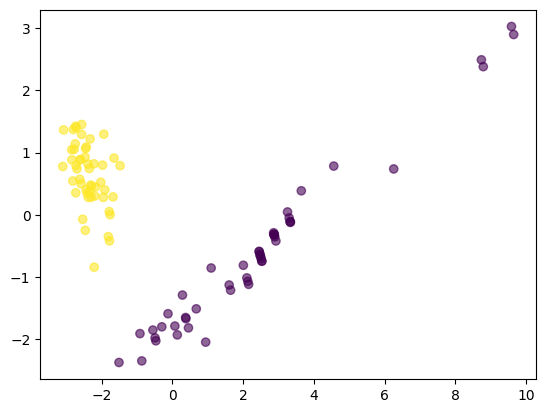

In [25]:
import matplotlib.pyplot as plt

plt.scatter(X_reduced[:,0], X_reduced[:,1],c=y,alpha=0.6)

From the picture, we confirm that the data is perfectly linearly separable, which explain why our classifier achieve such amazing metrics. 